In [30]:
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [11]:
plt.rcParams['font.size'] = 12

In [2]:
ce = [2,1,5,2,1,2,1,1,2,1,1,1,]
cm = [5]*25

In [21]:
cnt = Counter(ce)
ce_bp = []
for i in range(5):
    ce_bp.append(cnt[i+1])

In [23]:
cnt = Counter(cm)
cm_bp = []
for i in range(5):
    cm_bp.append(cnt[i+1])

In [33]:
np.array([1,2])

array([1, 2])

In [45]:
def normalize(x):
    return np.array(x)/np.sum(x)

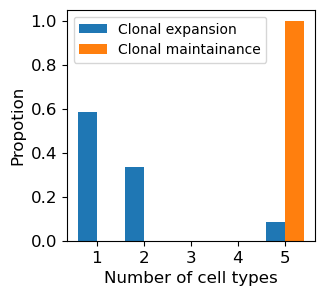

In [47]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.bar(np.array([1,2,3,4,5])-0.2, normalize(ce_bp), width=0.4, color='tab:blue', label='Clonal expansion')
ax.bar(np.array([1,2,3,4,5])+0.2, normalize(cm_bp), width=0.4, color='tab:orange', label='Clonal maintainance')
ax.set_xticks([1,2,3,4,5], '1,2,3,4,5'.split(','))
ax.set_xlabel('Number of cell types')
ax.set_ylabel('Propotion')
ax.legend(fontsize=10)

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
from Bio import Phylo
import argparse
import warnings

In [60]:
def cell_division_with_mt1(mt_muts, global_mutid, mut_rate, mt_copynumber=2, target_nmts=500):
    new_mts = []
    nmts = len(mt_muts)
    if nmts < target_nmts*0.8:
        mt_copynumber = 2.3
    elif nmts > target_nmts*1.2:
        mt_copynumber = 1.8
    else:
        mt_copynumber = 2
    
    if mt_copynumber == 2:
        new_mts = mt_muts*2
    elif mt_copynumber > 2:
        new_mts = mt_muts*2
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-2)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
    else:
        new_mts = mt_muts
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-1)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
        
    division = np.random.binomial(1, 0.5, len(new_mts)).astype(bool)
    while (np.sum(division) < min(0.4*len(new_mts), 100)) or (np.sum(~division) < min(0.4*len(new_mts), 100)):
        division = np.random.binomial(1, 0.5, len(new_mts)).astype(bool)
    cell1 = np.array(new_mts)[division]
    cell2 = np.array(new_mts)[~division]
    for i in np.random.choice(cell1, np.random.poisson(mut_rate)):
        global_mutid += 1
        i.add(global_mutid)
    for i in np.random.choice(cell2, np.random.poisson(mut_rate)):
        global_mutid += 1
        i.add(global_mutid)
    
    return list(cell1), list(cell2), global_mutid

def ncell_division_with_mt1(mt_muts, global_mutid, mut_rate, mt_copynumber=2, target_nmts=500):
    res = []
    for cell in mt_muts:
        res1, res2, global_mutid = cell_division_with_mt1(cell, global_mutid, mut_rate, mt_copynumber=mt_copynumber)
        res.append(res1)
        res.append(res2)
    n_cells = len(res)
    res_new = []
    for i in np.where(np.random.binomial(1, 0.5, n_cells))[0]:
        res_new.append(res[i])
    return res_new, global_mutid 

In [61]:
tree = Phylo.read(f'/data3/wangkun/mtsim_res/res_1113/linear_/147250/linear_tree_gt_147250.nwk', format='newick')
tree_origin = pd.read_csv(f'/data3/wangkun/mtsim_res/res_1113/linear_/147250/tree_origin_linear_147250.csv')
mt = pickle.load(open(f'/data3/wangkun/mtsim_res/res_1113/linear_/147250/mt_allmuts_mid_0.1_147250.pkl', 'rb'))

In [62]:
sel_cells = [i.name for i in tree.get_terminals()]
max_mut_id = max([max([max(list(i)+[0]) for i in mt[j]]+[0]) for j in sel_cells])

new_mts_15 = dict()
new_mts_50 = dict()
new_mts_100 = dict()
new_mts_300 = dict()
new_mts_800 = dict()

for cell in tqdm(tree.get_terminals()):
    new_mts_15[cell.name] = [mt[cell.name]]
    for _ in range(12):
        tmp = ncell_division_with_mt1(new_mts_15[cell.name], max_mut_id, 0.8, 2.2)
        new_mts_15[cell.name] = tmp[0]
        global_mutid = tmp[-1]
    for _ in range(3):
        tmp = ncell_division_with_mt1(new_mts_15[cell.name], max_mut_id, 0.8)
        new_mts_15[cell.name] = tmp[0]
        global_mutid = tmp[-1]
    new_mts_50[cell.name] = new_mts_15[cell.name]
    for _ in range(35):
        tmp = ncell_division_with_mt1(new_mts_50[cell.name], max_mut_id, 0.8)
        new_mts_50[cell.name] = tmp[0]
        global_mutid = tmp[-1]

    new_mts_100[cell.name] = new_mts_50[cell.name]
    for _ in range(50):
        tmp = ncell_division_with_mt1(new_mts_100[cell.name], max_mut_id, 0.8)
        new_mts_100[cell.name] = tmp[0]
        global_mutid = tmp[-1]

    new_mts_300[cell.name] = new_mts_100[cell.name]
    for _ in range(200):
        tmp = ncell_division_with_mt1(new_mts_300[cell.name], max_mut_id, 0.8)
        new_mts_300[cell.name] = tmp[0]
        global_mutid = tmp[-1]

    new_mts_800[cell.name] = new_mts_300[cell.name]
    for _ in range(500):
        tmp = ncell_division_with_mt1(new_mts_800[cell.name], max_mut_id, 0.8)
        new_mts_800[cell.name] = tmp[0]
        global_mutid = tmp[-1]

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
from tqdm.notebook import tqdm

In [63]:
path = '/data3/wangkun/mtsim_res/res_1113/linear_/449346'

In [65]:
mt15 = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/linear_/449346/mt_allmuts_mid_0.1_449346_15.pkl', 'rb'))

In [67]:
import os
os.chdir('..')

In [68]:
from mtDNAsim.sim_utils import *

In [70]:
freq15 = mut_freq(mt15)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 